In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Task 3 and 4_Loan_Data.csv', usecols=['fico_score', 'default'])

In [3]:
fico_summary = df.groupby('fico_score')['default'].agg(['count', 'sum']).reset_index()
fico_summary.columns = ['fico_score', 'n', 'k']

In [4]:
fico_summary = fico_summary.sort_values('fico_score').reset_index(drop=True)

In [5]:
def get_optimal_buckets(fico_summary_df, n_buckets=5):
    """
    Finds the optimal FICO score buckets by maximizing the log-likelihood function
    using a dynamic programming approach.
    """

    # Helper function to calculate the log-likelihood for a single bucket
    def log_likelihood(n, k):
        # Handle edge cases where k=0 or k=n to avoid log(0)
        if k == 0 or k == n:
            return 0
        p = k / n
        return k * np.log(p) + (n - k) * np.log(1 - p)

    # DP table to store the max log-likelihood for `i` buckets ending at FICO score `j`
    dp_table = np.full((n_buckets, len(fico_summary_df)), -np.inf)
    # Split table to store the optimal split point
    split_table = np.zeros((n_buckets, len(fico_summary_df)), dtype=int)

    # Initialize for the first bucket (i=0)
    for j in range(len(fico_summary_df)):
        n_j = fico_summary_df.loc[0:j, 'n'].sum()
        k_j = fico_summary_df.loc[0:j, 'k'].sum()
        dp_table[0, j] = log_likelihood(n_j, k_j)

    # Fill the DP table for the remaining buckets
    for i in range(1, n_buckets):
        for j in range(i, len(fico_summary_df)):
            for s in range(j):
                n_current_bucket = fico_summary_df.loc[s + 1:j, 'n'].sum()
                k_current_bucket = fico_summary_df.loc[s + 1:j, 'k'].sum()

                ll_current_bucket = log_likelihood(n_current_bucket, k_current_bucket)

                current_ll = dp_table[i - 1, s] + ll_current_bucket

                if current_ll > dp_table[i, j]:
                    dp_table[i, j] = current_ll
                    split_table[i, j] = s

    # Backtrack to find the optimal boundaries
    boundaries = []
    current_split = len(fico_summary_df) - 1
    for i in range(n_buckets - 1, 0, -1):
        split_index = split_table[i, current_split]
        boundaries.append(fico_summary_df.loc[split_index, 'fico_score'])
        current_split = split_index

    return sorted(boundaries)

# --- Find the optimal boundaries for a desired number of buckets ---
NUM_BUCKETS = 5
optimal_boundaries = get_optimal_buckets(fico_summary, n_buckets=NUM_BUCKETS)
print(f"Optimal FICO score boundaries for {NUM_BUCKETS} buckets: {optimal_boundaries}")


Optimal FICO score boundaries for 5 buckets: [np.int64(520), np.int64(580), np.int64(640), np.int64(696)]


In [7]:
def create_rating_map(fico_score: int) -> int:
    """
    Maps a FICO score to a rating (1 being the best) based on the optimal boundaries.
    """
    # Find the bucket index for the given FICO score
    bucket_index = np.searchsorted(optimal_boundaries, fico_score)
    # Reverse the rating: higher fico scores get lower (better) ratings
    rating = NUM_BUCKETS - bucket_index
    return rating

# Apply the rating map to the original dataframe
df['rating'] = df['fico_score'].apply(create_rating_map)

In [8]:
# Calculate the Probability of Default (PD) for each rating.
pd_by_rating = df.groupby('rating')['default'].mean().reset_index()
pd_by_rating.rename(columns={'default': 'Probability of Default (PD)'}, inplace=True)

print("\n--- Probability of Default (PD) by Optimal Rating ---")
print(pd_by_rating.sort_values('rating'))


--- Probability of Default (PD) by Optimal Rating ---
   rating  Probability of Default (PD)
0       1                     0.046470
1       2                     0.105099
2       3                     0.204479
3       4                     0.380952
4       5                     0.661130


/tmp/ipython-input-3510348465.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='Probability of Default (PD)', data=pd_by_rating, palette='coolwarm')


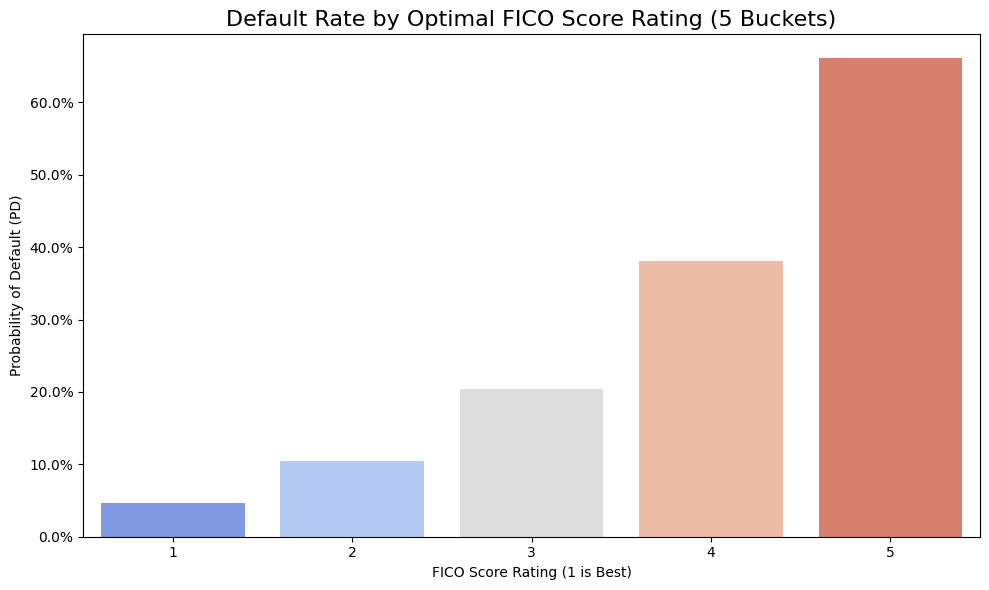

In [9]:
# Visualize the PD for each rating
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='Probability of Default (PD)', data=pd_by_rating, palette='coolwarm')
plt.title(f'Default Rate by Optimal FICO Score Rating ({NUM_BUCKETS} Buckets)', fontsize=16)
plt.ylabel('Probability of Default (PD)')
plt.xlabel('FICO Score Rating (1 is Best)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.1%}'.format))
plt.tight_layout()
plt.show()